<a href="https://colab.research.google.com/github/johanneslederer/pathsignatures/blob/main/FractionalSignatureCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fbm
!pip install iisignature
!pip install scikit-learn
!pip install scikit-fda
!pip install fbm
from google.colab import files
uploaded = files.upload()  # This will open a file upload dialog

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp311-cp311-linux_x86_64.whl size=3246730 sha256=d4b47299cf99612fbe5f098f8a0f9cc99daa5d72581da78017f24eeb03b26ba1
  Stored in directory: /root/.cache/pip/wheels/1c/f4/57/0b4d3787a07f20a3cd1a91835d6247f55ef899345267bcd6df
Successfully built iisignature
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.2 MB/s eta 0:00:00


Saving AirQualityUCI.csv to AirQualityUCI.csv


In [ ]:
import numpy as np
import pandas as pd
import os
import iisignature as isig
import matplotlib.pyplot as plt
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSpline, VectorValued
from skfda.ml.regression import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import cm


# Load air quality data
DATA_DIR = '/content'

def get_air_quality(univariate_air_quality=False):
    """ Returns the Air Quality data """
    data = pd.read_csv(os.path.join(DATA_DIR, 'AirQualityUCI.csv'), sep=';', header=0)
    # Data cleaning
    data = data.dropna(how='all')
    data[['T', 'RH', 'AH', 'CO(GT)']] = data[['T', 'RH', 'AH', 'CO(GT)']].apply(lambda x: x.str.replace(',', '.'))
    data['Hour'] = data['Time'].str.split('.', expand=True)[0]
    data['DateHour'] = data['Date'] + '/' + data['Hour']
    date_time_index = pd.to_datetime(data['DateHour'], format='%d/%m/%Y/%H')
    data.index = date_time_index

    data = data[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'NO2(GT)']]
    data = data.astype(float)
    data = data.replace(to_replace=-200, value=None)
    data = data.fillna(method='ffill')

    if univariate_air_quality:
        keep_cols = ['PT08.S4(NO2)']
    else:
        keep_cols = ['PT08.S4(NO2)', 'T', 'RH']

    list_X = []
    list_Y = []

    window_length = 24 * 7 + 1
    for window in data.rolling(window=window_length):
        if len(window) == window_length:
            list_X.append(window[keep_cols][:-1].to_numpy())
            list_Y.append(window['NO2(GT)'].iloc[-1])

    X = np.stack(list_X)
    Y = np.stack(list_Y)
    return X, Y / 100

# Lasso regression implementation with gradient descent
def lasso_regression_Sig(X, y, alpha, lr=0.001, epochs=1000):
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    errors = []
    for epoch in range(epochs):
        y_pred = X @ weights + bias
        error = y_pred - y
        mse = np.mean(error**2)
        errors.append(mse)
        dW = (1 / m) * (X.T @ error) + alpha * np.sign(weights)
        db = (1 / m) * np.sum(error)
        weights -= lr * dW
        bias -= lr * db

    return weights, bias, errors

# Data preparation functions
def get_train_test_data(X_type, ntrain=None, nval=None, univariate_air_quality=False, scale_X=False, seed=None):
    if X_type == 'air_quality':
        X, Y = get_air_quality(univariate_air_quality=univariate_air_quality)
        Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.33)
    else:
        raise NameError('X_type not well specified')

    if scale_X:
        for i in range(Xtrain.shape[2]):
            scaler = StandardScaler()
            scaler.fit(Xtrain[:, :, i])
            Xtrain[:, :, i] = scaler.transform(Xtrain[:, :, i])
            Xval[:, :, i] = scaler.transform(Xval[:, :, i])

    return Xtrain, Ytrain, Xval, Yval

# Add time as an extra dimension
def add_time(X):
    times = np.tile(np.linspace(0, 1, X.shape[1]), (X.shape[0], 1))
    Xtime = np.concatenate([X, times.reshape((times.shape[0], times.shape[1], 1))], axis=2)
    return Xtime

# Get signature of X with truncation order k
def get_sigX(X, k):
    if k == 0:
        return np.full((np.shape(X)[0], 1), 1)
    else:
        d = X.shape[2]
        sigX = np.zeros((np.shape(X)[0], isig.siglength(d, k) + 1))
        sigX[:, 0] = 1
        for i in range(np.shape(X)[0]):
            sigX[i, 1:] = isig.sig(X[i, :, :], k)
        return sigX

# Main function
def main():
    Xtrain, Ytrain, Xval, Yval = get_train_test_data(X_type='air_quality', ntrain=500, nval=200, univariate_air_quality=False, scale_X=True, seed=42)
    Xtimetrain = add_time(Xtrain)
    Xtimeval = add_time(Xval)

    # Perform Lasso Regression
    alpha = 0.65
    learning_rate = 0.001
    epochs = 800
    weights, bias, mse_history_train = lasso_regression_Sig(Xtimetrain.reshape(Xtimetrain.shape[0], -1), Ytrain, alpha=alpha, lr=learning_rate, epochs=epochs)

    # Plot training MSE
    plt.figure(figsize=(10, 6))
    plt.plot(mse_history_train, label="Train MSE", color='blue')

    # Test the Model
    Xval_sig = Xtimeval.reshape(Xtimeval.shape[0], -1)  # Flatten for lasso regression
    Yval_pred = Xval_sig @ weights + bias
    mse_test = np.mean((Yval - Yval_pred) ** 2)
    plt.axhline(y=mse_test, color='red', linestyle='--', label='Lasso Regression Test MSE')

    # Perform Lasso Regression for different signature levels
    levels = [2, 3]
    num_levels = len(levels)
    ii = 0
    for level in levels:
        ii += 1
        cmap = cm.viridis
        color = cmap(ii / num_levels)
        signature_dim = isig.siglength(Xtimetrain.shape[2], level)
        Xtrain_sig = get_sigX(Xtimetrain, level)
        Xval_sig = get_sigX(Xtimeval, level)

        weights, bias, mse_train = lasso_regression_Sig(Xtrain_sig, Ytrain, alpha=alpha, lr=learning_rate, epochs=epochs)

        # Plot MSE for each level
        plt.plot(mse_train, label=f"Train MSE (Level {level})")
        Xval_sig = get_sigX(Xtimeval, level)
        Yval_pred = Xval_sig @ weights + bias
        mse_test_level = np.mean((Yval - Yval_pred) ** 2)
        plt.axhline(y=mse_test_level, color=color, linestyle='--', label=f'Signature Regression Test MSE (Level {level})')

    # Final plot for all MSE curves
    plt.title("Lasso Regression MSE for Different Signature Levels")
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    main()


KeyboardInterrupt: 

In [ ]:
# MODIFIED SCRIPT


import numpy as np
import pandas as pd
import os
import iisignature as isig
import matplotlib.pyplot as plt
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSpline, VectorValued
from skfda.ml.regression import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import cm

from sklearn.linear_model import Lasso, LassoCV


# Load air quality data
DATA_DIR = '/content'

def get_air_quality(univariate_air_quality=False):
    """ Returns the Air Quality data """
    data = pd.read_csv(os.path.join(DATA_DIR, 'AirQualityUCI.csv'), sep=';', header=0)
    # Data cleaning
    data = data.dropna(how='all')
    data[['T', 'RH', 'AH', 'CO(GT)']] = data[['T', 'RH', 'AH', 'CO(GT)']].apply(lambda x: x.str.replace(',', '.'))
    data['Hour'] = data['Time'].str.split('.', expand=True)[0]
    data['DateHour'] = data['Date'] + '/' + data['Hour']
    date_time_index = pd.to_datetime(data['DateHour'], format='%d/%m/%Y/%H')
    data.index = date_time_index

    data = data[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'NO2(GT)']]
    data = data.astype(float)
    data = data.replace(to_replace=-200, value=None)
    data = data.fillna(method='ffill')

    if univariate_air_quality:
        keep_cols = ['PT08.S4(NO2)']
    else:
        keep_cols = ['PT08.S4(NO2)', 'T', 'RH']

    list_X = []
    list_Y = []

    window_length = 24 * 7 + 1
    for window in data.rolling(window=window_length):
        if len(window) == window_length:
          w = window[keep_cols][:-1]
          list_X.append(((w - w.mean())/w.std()).to_numpy())
          list_Y.append(window['NO2(GT)'].iloc[-1])

    X = np.stack(list_X)
    Y = np.stack(list_Y)
    return X, Y / 100

# Lasso regression implementation with gradient descent
def lasso_regression_Sig(X, y, alpha, lr=0.001, epochs=1000):
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    errors = []
    for epoch in range(epochs):
        y_pred = X @ weights + bias
        error = y_pred - y
        mse = np.mean(error**2)
        errors.append(mse)
        dW = (1 / m) * (X.T @ error) + alpha * np.sign(weights)
        db = (1 / m) * np.sum(error)
        weights -= lr * dW
        bias -= lr * db

    return weights, bias, errors

# Data preparation functions
def get_train_test_data(X_type, ntrain=None, nval=None, univariate_air_quality=False, scale_X=False, seed=None):
    if X_type == 'air_quality':
        X, Y = get_air_quality(univariate_air_quality=univariate_air_quality)
        Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.33)
    else:
        raise NameError('X_type not well specified')

    if scale_X:
        for i in range(Xtrain.shape[2]):
            scaler = StandardScaler()
            scaler.fit(Xtrain[:, :, i])
            Xtrain[:, :, i] = scaler.transform(Xtrain[:, :, i])
            Xval[:, :, i] = scaler.transform(Xval[:, :, i])

    return Xtrain, Ytrain, Xval, Yval

# Add time as an extra dimension
def add_time(X):
    times = np.tile(np.linspace(0, 1, X.shape[1]), (X.shape[0], 1))
    Xtime = np.concatenate([X, times.reshape((times.shape[0], times.shape[1], 1))], axis=2)
    return Xtime

# Get signature of X with truncation order k
def get_sigX(X, k):
    if k == 0:
        return np.full((np.shape(X)[0], 1), 1)
    else:
        d = X.shape[2]
        sigX = np.zeros((np.shape(X)[0], isig.siglength(d, k) + 1))
        sigX[:, 0] = 1
        for i in range(np.shape(X)[0]):
            sigX[i, 1:] = isig.sig(X[i, :, :], k)
        return sigX

# Main function
def fit_models():

    Xtrain, Ytrain, Xval, Yval = get_train_test_data(X_type='air_quality', ntrain=500, nval=200, univariate_air_quality=False, scale_X=True)
    Xtimetrain = add_time(Xtrain)
    Xtimeval = add_time(Xval)


    models = {}
    preds = {}
    mses = {}

    preds['truth'] = Yval



    model_basic = LassoCV()
    model_basic.fit(Xtrain.reshape((Xtrain.shape[0], -1), order='F'), Ytrain)
    pred_basic = model_basic.predict(Xval.reshape((Xval.shape[0], -1), order='F'))
    mse_test_basic = np.mean((pred_basic - Yval)**2)

    models['basic'] = model_basic
    mses['basic'] = mse_test_basic
    preds['basic'] = pred_basic

    # Perform Lasso Regression for different signature levels
    levels = [2, 3]

    for level in levels:
        signature_dim = isig.siglength(Xtimetrain.shape[2], level)
        Xtrain_sig = get_sigX(Xtimetrain, level)
        Xval_sig = get_sigX(Xtimeval, level)

        model_sig = LassoCV()
        model_sig.fit(Xtrain_sig, Ytrain)
        pred_sig = model_sig.predict(Xval_sig)
        mse_test_sig = np.mean((pred_sig - Yval)**2)

        models[f'level{level}'] = model_sig
        mses[f'level{level}'] = mse_test_sig
        preds[f'level{level}'] = pred_sig

    return models, preds, mses


# compute results
models, preds, mses = fit_models()

<ipython-input-8-b8083107a106>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')
<ipython-input-8-b8083107a106>:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.fillna(method='ffill')


In [ ]:
# analize results

print('MSE basic: ' + str(mses['basic']))
print('MSE level 2: ' + str(mses['level2']))
print('MSE level 3: ' + str(mses['level3']))



MSE basic: 0.14635140973596147
MSE level 2: 0.13055467167112123
MSE level 3: 0.1128205066112078


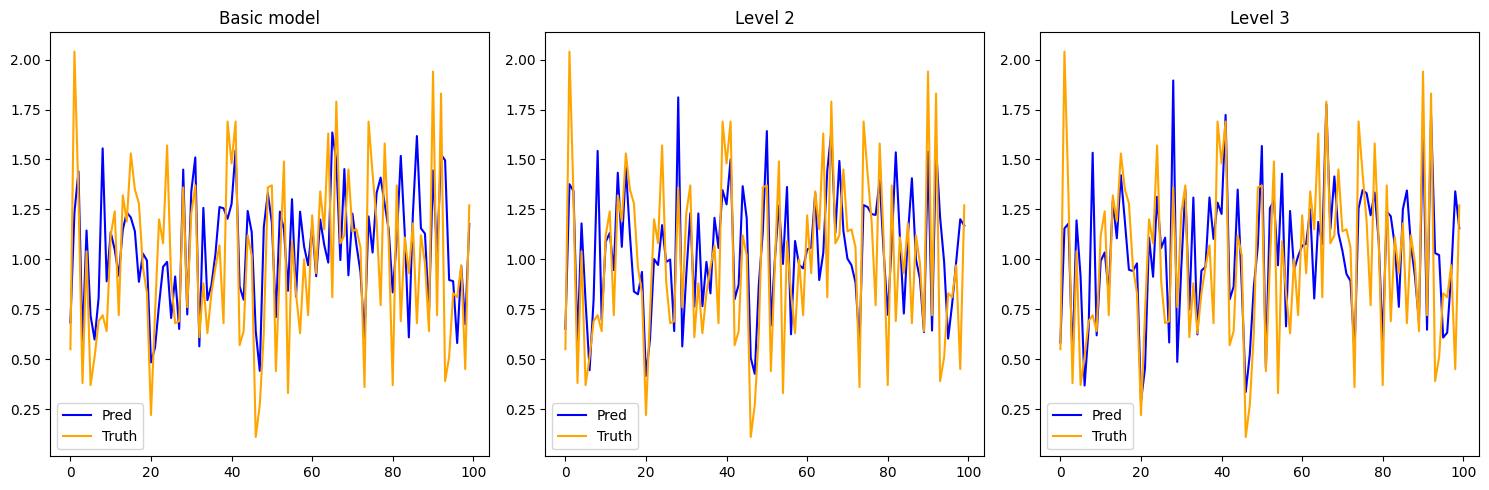

In [ ]:

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot the data on each subplot
axes[0].plot(preds['basic'][:100], label="Pred", color='blue')
axes[0].plot(preds['truth'][:100], label="Truth", color='orange')
axes[0].set_title('Basic model')
axes[0].legend()

axes[1].plot(preds['level2'][:100], label="Pred", color='blue')
axes[1].plot(preds['truth'][:100], label="Truth", color='orange')
axes[1].set_title('Level 2')
axes[1].legend()

axes[2].plot(preds['level3'][:100], label="Pred", color='blue')
axes[2].plot(preds['truth'][:100], label="Truth", color='orange')
axes[2].set_title('Level 3')
axes[2].legend()
# Adjust the spacing between subplots
plt.tight_layout()

In [ ]:
preds['level3'].shape


(3033,)

68.3619544148849
18.47053997202352
8.393857552740947
7.127151577721503


/usr/local/lib/python3.11/dist-packages/fbm/fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(


6.833172618468655


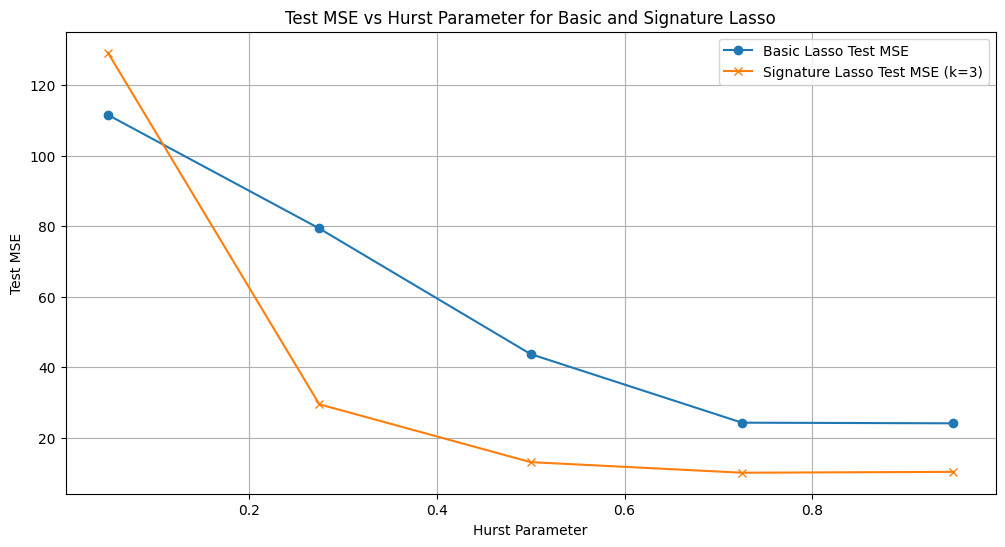

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from fbm import FBM
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
import iisignature as isig

# Generate Hurst parameters
hurst_values = np.linspace(0.05, 0.95, 5)
#hurst_values = [0.3]
n_realizations = 500
num_samples = 50
d = 1
noise_sigma = 0.1

def generate_fbm_data(hurst, n_realizations, num_samples):
    fbm_data = np.zeros((n_realizations, num_samples, 2))
    for i in range(n_realizations):
        path_dim1 = FBM(n=num_samples - 1, hurst=hurst).fbm()
        path_dim2 = FBM(n=num_samples - 1, hurst=hurst).fbm()
        fbm_data[i, :, 0] = path_dim1
        fbm_data[i, :, 1] = path_dim2
    return fbm_data

# Add time dimension for signature

def add_time(X):
    times = np.tile(np.linspace(0, 1, X.shape[1]), (X.shape[0], 1))
    return np.concatenate([X, times.reshape(X.shape[0], X.shape[1], 1)], axis=2)

def get_sigX(X, k):
    if k == 0:
        return np.ones((X.shape[0], 1))
    else:
        d_in = X.shape[2]
        sig_dim = isig.siglength(d_in, k)
        sigX = np.zeros((X.shape[0], sig_dim + 1))
        sigX[:, 0] = 1.0
        for i in range(X.shape[0]):
            sigX[i, 1:] = isig.sig(X[i, :, :], k)
        return sigX

# Evaluate MSE for different Hurst values
final_mse_values = []
final_mse_values_sig = []
k = 3

for hurst in hurst_values:
    # Generate fBm data
    fbm_data = generate_fbm_data(hurst, n_realizations, num_samples)

    # Prepare the basic dataset
    X_basic = fbm_data.reshape(n_realizations, -1)
    np.random.seed(42)
    A_basic = np.random.randn(X_basic.shape[1], d)
    Y_basic = X_basic @ A_basic + noise_sigma * np.random.randn(n_realizations, d)

    # Split into train and test
    Xb_train, Xb_test, Yb_train, Yb_test = train_test_split(
        X_basic, Y_basic, test_size=0.2, random_state=123
    )

    # Train and evaluate Lasso for Basic Dataset using sklearn
    model_basic = Lasso(alpha=0.2, max_iter=2000, random_state=123)
    model_basic.fit(Xb_train, Yb_train)
    mse_test = np.mean((model_basic.predict(Xb_test) - Yb_test)**2)
    final_mse_values.append(mse_test)

    # Prepare the signature dataset
    fbm_time = add_time(fbm_data)
    X_sig = get_sigX(fbm_time, k)
    A_sig = np.random.randn(X_sig.shape[1], d)
    Y_sig = X_sig @ A_sig + noise_sigma * np.random.randn(n_realizations, d)

    Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(
        X_sig, Y_sig, test_size=0.2, random_state=123
    )

    # Train and evaluate Lasso for Signature Dataset using sklearn
    model_sig = Lasso(alpha=0.2, max_iter=2000, random_state=123)
    model_sig.fit(Xs_train, Ys_train)
    mse_test_sig = np.mean((model_sig.predict(Xs_test) - Ys_test)**2)
    final_mse_values_sig.append(mse_test_sig)

    my_pred = np.mean(Ys_train)
    print(np.mean((my_pred - Ys_test)**2))


# Plot Test MSE vs Hurst
plt.figure(figsize=(12, 6))
plt.plot(hurst_values, final_mse_values[0:43], marker='o', label='Basic Lasso Test MSE')
plt.plot(hurst_values, final_mse_values_sig[0:43], marker='x', label=f'Signature Lasso Test MSE (k={k})')
plt.xlabel("Hurst Parameter")
plt.ylabel("Test MSE")
plt.title("Test MSE vs Hurst Parameter for Basic and Signature Lasso")
plt.grid(True)
plt.legend()
plt.show()


0.9913348193112513
0.697573080096139
0.5126812627313249
0.3893235023882467


/usr/local/lib/python3.11/dist-packages/fbm/fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14690824777352418, tolerance: 0.09300274549572367
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24232326341711996, tolerance: 0.09300274549572367
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want

0.30445868339237714


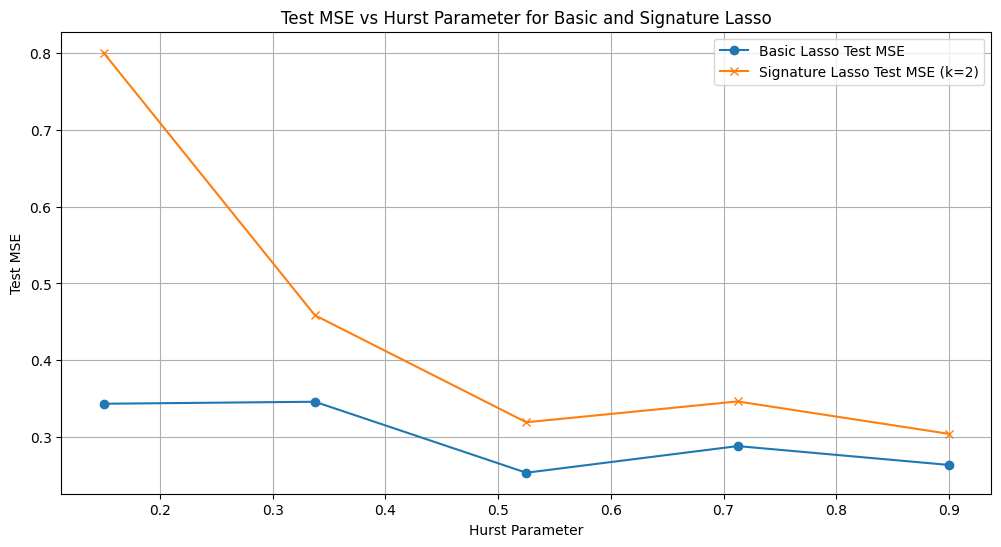

In [ ]:
# GENERATING FROM LINEAR REGRESSION MODEL / NON LINEAR REGRESSION MODEL Y = X BETA + EPS
# MODIFIED SCRIPT: 16.01.25

# generating model int_0^1 beta(s) f(X(s)) + eps
# we compare Y = \sum_j \beta_j X_{t_j}
#            Y = \sum_j \beta_j sig(X) {t_j}
# coefficients fitted by LassoCV in both cases

import numpy as np
import matplotlib.pyplot as plt
from fbm import FBM
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
import iisignature as isig

# Generate Hurst parameters
hurst_values = np.linspace(0.15, 0.9, 5)
n_realizations = 500
num_samples = 50
d = 1
noise_sigma = 0.5

def generate_fbm_data(hurst, n_realizations, num_samples):
    fbm_data = np.zeros((n_realizations, num_samples, 2))
    for i in range(n_realizations):
        path_dim1 = FBM(n=num_samples - 1, hurst=hurst).fbm()
        path_dim2 = FBM(n=num_samples - 1, hurst=hurst).fbm()
        fbm_data[i, :, 0] = path_dim1
        fbm_data[i, :, 1] = path_dim2
    return fbm_data

# Add time dimension for signature

def add_time(X):
    times = np.tile(np.linspace(0, 1, X.shape[1]), (X.shape[0], 1))
    return np.concatenate([X, times.reshape(X.shape[0], X.shape[1], 1)], axis=2)

def get_sigX(X, k):
    if k == 0:
        return np.ones((X.shape[0], 1))
    else:
        d_in = X.shape[2]
        sig_dim = isig.siglength(d_in, k)
        sigX = np.zeros((X.shape[0], sig_dim + 1))
        sigX[:, 0] = 1.0
        for i in range(X.shape[0]):
            sigX[i, 1:] = isig.sig(X[i, :, :], k)
        return sigX

def fit_lasso(X, y):
  # Find lambda.1se
  lasso_cv = LassoCV(cv=5, random_state=0, max_iter=10000, tol=0.001).fit(X, y)
  mse_mean = np.mean(lasso_cv.mse_path_, axis=1)
  mse_std = np.std(lasso_cv.mse_path_, axis=1)
  idx_min_mse = np.argmin(mse_mean)
  mse_1se = mse_mean[idx_min_mse] + mse_std[idx_min_mse]
  idx_1se = np.argmax(mse_mean <= mse_1se)
  lambda_1se = lasso_cv.alphas_[idx_1se]
  # Fit Lasso with lambda.1se
  lasso_1se = Lasso(alpha=lambda_1se, max_iter=10000, tol=0.001).fit(X, y)
  return lasso_1se


# Evaluate MSE for different Hurst values
final_mse_values = []
final_mse_values_sig = []
k = 2

for hurst in hurst_values:
    # Generate fBm data
    fbm_data = generate_fbm_data(hurst, n_realizations, num_samples)

    # Prepare the basic dataset
    X_basic = fbm_data.reshape((n_realizations, -1), order='F')
    #np.random.seed(42)
    A_star = 5*(np.random.randn(X_basic.shape[1], d))
    # A_star = 4*np.sin(np.linspace(0, 1, X_basic.shape[1])).reshape(X_basic.shape[1], d)
    # generating linear functional of trajectory
    Y_star = ((X_basic) @ A_star / num_samples + noise_sigma * np.random.randn(n_realizations, d))[:,0]

    # Split into train and test
    Xb_train, Xb_test, Yb_train, Yb_test = train_test_split(
        X_basic, Y_star, test_size=0.2
    )

    # Train and evaluate Lasso for Basic Dataset using sklearn
    model_basic = fit_lasso(Xb_train, Yb_train)
    mse_test = np.mean((model_basic.predict(Xb_test) - Yb_test)**2)
    final_mse_values.append(mse_test)

    # Prepare the signature dataset
    fbm_time = add_time(fbm_data)
    X_sig = get_sigX(fbm_time, k)
    # A_sig = np.random.randn(X_sig.shape[1], d)
    # Y_sig = X_sig @ A_sig + noise_sigma * np.random.randn(n_realizations, d)


    Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(
        X_sig, Y_star, test_size=0.2
    )

    # Train and evaluate Lasso for Signature Dataset using sklearn
    model_sig = fit_lasso(Xs_train, Ys_train)

    mse_test_sig = np.mean((model_sig.predict(Xs_test) - Ys_test)**2)
    final_mse_values_sig.append(mse_test_sig)


    my_pred = np.mean(Ys_train)
    print(np.mean((my_pred - Ys_test)**2))

# Plot Test MSE vs Hurst
plt.figure(figsize=(12, 6))
plt.plot(hurst_values, final_mse_values, marker='o', label='Basic Lasso Test MSE')
plt.plot(hurst_values, final_mse_values_sig, marker='x', label=f'Signature Lasso Test MSE (k={k})')
plt.xlabel("Hurst Parameter")
plt.ylabel("Test MSE")
plt.title("Test MSE vs Hurst Parameter for Basic and Signature Lasso")
plt.grid(True)
plt.legend()
plt.show()


(array([ 2.,  5., 10., 18., 23., 18.,  8.,  8.,  4.,  4.]),
 array([-2.20588066, -1.781485  , -1.35708933, -0.93269367, -0.50829801,
        -0.08390235,  0.34049331,  0.76488897,  1.18928464,  1.6136803 ,
         2.03807596]),
 <BarContainer object of 10 artists>)

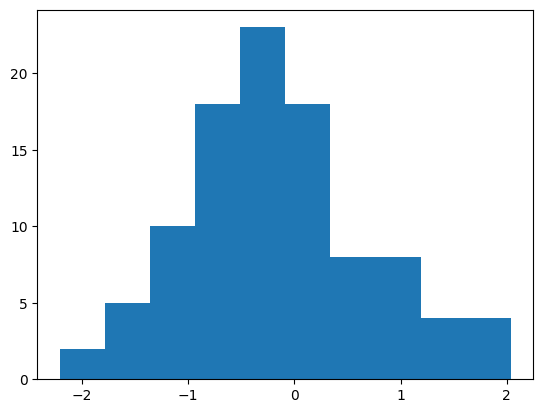

In [ ]:
plt.hist(Yb_test)

0.30086089396165216
0.2840285543372206
0.2635368138837408


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009368808069957879, tolerance: 0.009249724315475567
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009855837210757556, tolerance: 0.009249724315475567
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011213925508045008, tolerance: 0.009633691994442438
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:6

0.25760238990828094


/usr/local/lib/python3.11/dist-packages/fbm/fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0118235680263723, tolerance: 0.011364062986543865
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012448635502178007, tolerance: 0.010921307903362208
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might wa

0.29950276448318297


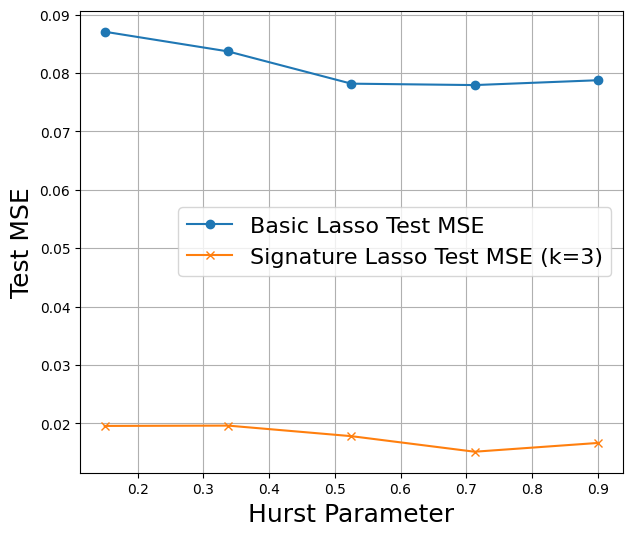

In [ ]:
# GENERATING OPTION PRICING FUNCTIONALS Y = MAX(X_t  - K, 0)
# MODIFIED SCRIPT: 17.01.25

# generating model int_0^1 beta(s) f(X(s)) + eps
# we compare Y = \sum_j \beta_j X_{t_j}
#            Y = \sum_j \beta_j sig(X) {t_j}
# coefficients fitted by LassoCV in both cases

import numpy as np
import matplotlib.pyplot as plt
from fbm import FBM
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
import iisignature as isig

# Generate Hurst parameters
hurst_values = np.linspace(0.15, 0.9, 5)
n_realizations = 500
num_samples = 100
d = 1
noise_sigma = 0.1

def generate_fbm_data(hurst, n_realizations, num_samples, d=1):
    fbm_data = np.zeros((n_realizations, num_samples, d))
    for i in range(n_realizations):
      for j in range(d):
        path_dim = FBM(n=num_samples - 1, hurst=hurst).fbm()
        fbm_data[i, :, j] = path_dim
    return fbm_data

# Add time dimension for signature

def add_time(X):
    times = np.tile(np.linspace(0, 1, X.shape[1]), (X.shape[0], 1))
    return np.concatenate([X, times.reshape(X.shape[0], X.shape[1], 1)], axis=2)

def get_sigX(X, k):
    if k == 0:
        return np.ones((X.shape[0], 1))
    else:
        d_in = X.shape[2]
        sig_dim = isig.siglength(d_in, k)
        sigX = np.zeros((X.shape[0], sig_dim + 1))
        sigX[:, 0] = 1.0
        for i in range(X.shape[0]):
            sigX[i, 1:] = isig.sig(X[i, :, :], k)
        return sigX

# Evaluate MSE for different Hurst values
final_mse_values = []
final_mse_values_sig = []
k = 3
for hurst in hurst_values:
    # Generate fBm data
    fbm_data = generate_fbm_data(hurst, n_realizations, num_samples)

    # Prepare the basic dataset
    X_basic = 1 + fbm_data.reshape((n_realizations, -1), order='F')
    np.random.seed(42)
    # A_star = 10*np.random.randn(X_basic.shape[1], d)
    # A_star = np.sin(np.linspace(0, 1, X_basic.shape[1])).reshape(X_basic.shape[1], d)
    # generating linear functional of trajectory
    # Y_star = np.sin(X_basic) @ A_star/num_samples + noise_sigma * np.random.randn(n_realizations, d)
    # Y_star = np.maximum(np.mean(X_basic, axis=1) - 1, 0)  + noise_sigma * np.random.randn(n_realizations)  # ASIAN: OK
    # Y_star = np.maximum(np.max(X_basic, axis=1) - 1, 0)  + noise_sigma * np.random.randn(n_realizations)  # LOOKBACK:
    # Y_star = np.maximum(X_basic[:, num_samples-1] - 1, 0)  + noise_sigma * np.random.randn(n_realizations)  # CALL: OK
    # Y_star = np.maximum(1 - X_basic[:, num_samples-1], 0)  + noise_sigma * np.random.randn(n_realizations)  # PUT: OK
    # Split into train and test
    Xb_train, Xb_test, Yb_train, Yb_test = train_test_split(
        X_basic, Y_star, test_size=0.2, random_state=123
    )

    # Train and evaluate Lasso for Basic Dataset using sklearn
    model_basic = LassoCV(random_state=123)
    model_basic.fit(Xb_train, Yb_train)
    mse_test = np.mean((model_basic.predict(Xb_test) - Yb_test)**2)
    final_mse_values.append(mse_test)

    # Prepare the signature dataset
    fbm_time = add_time(fbm_data)
    X_sig = get_sigX(fbm_time, k)
    # A_sig = np.random.randn(X_sig.shape[1], d)
    # Y_sig = X_sig @ A_sig + noise_sigma * np.random.randn(n_realizations, d)


    Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(
        X_sig, Y_star, test_size=0.2, random_state=123
    )

    # Train and evaluate Lasso for Signature Dataset using sklearn
    model_sig = LassoCV(random_state=123)
    model_sig.fit(Xs_train, Ys_train)
    mse_test_sig = np.mean((model_sig.predict(Xs_test) - Ys_test)**2)
    final_mse_values_sig.append(mse_test_sig)

    my_pred = np.mean(Ys_train)
    print(np.mean((my_pred - Ys_test)**2))


# Plot Test MSE vs Hurst
plt.figure(figsize=(7, 6))
plt.plot(hurst_values, final_mse_values, marker='o', label='Basic Lasso Test MSE')
plt.plot(hurst_values, final_mse_values_sig, marker='x', label=f'Signature Lasso Test MSE (k={k})')
plt.xlabel("Hurst Parameter", fontsize=18)
plt.ylabel("Test MSE", fontsize=18)
#plt.title("Test MSE vs Hurst Parameter for Basic and Signature Lasso", fontsize=18)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()



In [ ]:
X_basic.shape

(500, 100)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from fbm import FBM
import iisignature as isig
from sklearn.model_selection import train_test_split

#  Generate 2D fBm data
n_realizations = 500
num_samples = 50
hurst = 0.95

fbm_data = np.zeros((n_realizations, num_samples, 2))
for i in range(n_realizations):
    path_dim1 = FBM(n=num_samples - 1, hurst=hurst).fbm()
    path_dim2 = FBM(n=num_samples - 1, hurst=hurst).fbm()
    fbm_data[i, :, 0] = path_dim1
    fbm_data[i, :, 1] = path_dim2

#  Basic Lasso Dataset
X_basic = fbm_data.reshape(n_realizations, -1)  # shape (100, 40)

d = 6  # dimension of output
np.random.seed(42)
A_basic = np.random.randn(X_basic.shape[1], d)
noise_sigma = 0.1

Y_basic = X_basic @ A_basic + noise_sigma * np.random.randn(n_realizations, d)

# Split
Xb_train, Xb_test, Yb_train, Yb_test = train_test_split(
    X_basic, Y_basic, test_size=0.2, random_state=123
)

# Signature Data
def add_time(X):
    times = np.tile(np.linspace(0, 1, X.shape[1]), (X.shape[0], 1))
    return np.concatenate([X, times.reshape(X.shape[0], X.shape[1], 1)], axis=2)

def get_sigX(X, k):
    if k == 0:
        return np.ones((X.shape[0], 1))
    else:
        d_in = X.shape[2]
        sig_dim = isig.siglength(d_in, k)
        sigX = np.zeros((X.shape[0], sig_dim + 1))
        sigX[:, 0] = 1.0
        for i in range(X.shape[0]):
            sigX[i, 1:] = isig.sig(X[i, :, :], k)
        return sigX

fbm_time = add_time(fbm_data)
k_values = [2]

SigX_dict = {}
Y_sig_dict = {}
for k in k_values:
    X_sig_k = get_sigX(fbm_time, k)
    A_sig_k = np.random.randn(X_sig_k.shape[1], d)
    Y_sig_k = X_sig_k @ A_sig_k + noise_sigma * np.random.randn(n_realizations, d)
    SigX_dict[k] = X_sig_k
    Y_sig_dict[k] = Y_sig_k

# Lasso that returns MSE history
def lasso_multioutput_mse_history(X_train, Y_train, X_test, Y_test,
                                  alpha=0.1, lr=0.001, epochs=1000):
    """
    Multi-output Lasso with gradient descent.
    Returns:
      W, b
      train_mse_history (list of length epochs)
      test_mse_history  (list of length epochs)
    """
    n_train, p = X_train.shape
    d_out = Y_train.shape[1]

    # Initialize
    W = np.zeros((p, d_out))
    b = np.zeros(d_out)

    train_mse_history = []
    test_mse_history = []

    for e in range(epochs):
        # Training predictions
        Y_pred_train = X_train @ W + b
        error_train = Y_pred_train - Y_train
        mse_train = np.mean(error_train**2)
        train_mse_history.append(mse_train)

        # Test predictions
        Y_pred_test = X_test @ W + b
        mse_test = np.mean((Y_pred_test - Y_test)**2)
        test_mse_history.append(mse_test)

        # Gradients from train set
        dW = (X_train.T @ error_train) / n_train
        db = np.mean(error_train, axis=0)

        # L1 penalty
        W -= lr * (dW + alpha * np.sign(W))
        b -= lr * db

    return W, b, train_mse_history, test_mse_history

# Train "Basic Lasso"
alpha = 0.3
learning_rate = 0.001
epochs = 2000

Wb, bb, mse_train_basic, mse_test_basic = lasso_multioutput_mse_history(
    Xb_train, Yb_train, Xb_test, Yb_test, alpha=alpha, lr=learning_rate, epochs=epochs
)

# Train "Signature Lasso"
results_sig = {}
for k in k_values:
    X_train_k, X_test_k, Y_train_k, Y_test_k = train_test_split(
        SigX_dict[k], Y_sig_dict[k], test_size=0.2, random_state=123
    )
    Wk, bk, mse_train_k, mse_test_k = lasso_multioutput_mse_history(
        X_train_k, Y_train_k, X_test_k, Y_test_k,
        alpha=alpha, lr=learning_rate, epochs=epochs
    )
    results_sig[k] = {
        'train_mse': mse_train_k,
        'test_mse':  mse_test_k
    }

# Plot (Train MSE vs. epoch), final Test MSE lines
plt.figure(figsize=(10, 6))

# 7a) Plot Basic Lasso train MSE
plt.plot(mse_train_basic, label="Basic Lasso (Train)", color='blue')

# 7b) Plot final test MSE (horizontal line)
final_mse_basic = mse_test_basic[-1]
plt.axhline(y=final_mse_basic, color='blue', linestyle='--',
            label=f"Basic Lasso (Final Test MSE={final_mse_basic:.4f})")

#  Plot Signature Lasso train MSE , final test MSE
colors = ['red', 'green', 'orange']
for i, k in enumerate(k_values):
    c = colors[i % len(colors)]
    train_mse_k = results_sig[k]['train_mse']
    test_mse_k  = results_sig[k]['test_mse']

    # Train MSE curve
    plt.plot(train_mse_k, label=f"Sig(k={k}) (Train)", color=c)

    # Horizontal line at final test MSE
    final_test_mse = test_mse_k[-1]
    plt.axhline(y=final_test_mse, color=c, linestyle='--',
                label=f"Sig(k={k}) (Final Test MSE={final_test_mse:.4f})")

plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Comparison of Basic vs. Signature Lasso (Hurst = 0.95)")
plt.grid(True)
plt.legend()
plt.show()

#  Print final test MSE numeric values
print(f"Basic Lasso final test MSE = {final_mse_basic:.4f}")
for k in k_values:
    mse_k = results_sig[k]['test_mse'][-1]
    print(f"Signature (k={k}) final test MSE = {mse_k:.4f}")


In [ ]:
import numpy as np
import pandas as pd
import os
import iisignature as isig
import matplotlib.pyplot as plt
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSpline, VectorValued
from skfda.ml.regression import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import cm


# Load air quality data
DATA_DIR = '/content'

def get_air_quality(univariate_air_quality=False):
    """ Returns the Air Quality data """
    data = pd.read_csv(os.path.join(DATA_DIR, 'AirQualityUCI.csv'), sep=';', header=0)
    # Data cleaning
    data = data.dropna(how='all')
    data[['T', 'RH', 'AH', 'CO(GT)']] = data[['T', 'RH', 'AH', 'CO(GT)']].apply(lambda x: x.str.replace(',', '.'))
    data['Hour'] = data['Time'].str.split('.', expand=True)[0]
    data['DateHour'] = data['Date'] + '/' + data['Hour']
    date_time_index = pd.to_datetime(data['DateHour'], format='%d/%m/%Y/%H')
    data.index = date_time_index

    data = data[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'NO2(GT)']]
    data = data.astype(float)
    data = data.replace(to_replace=-200, value=None)
    data = data.fillna(method='ffill')

    if univariate_air_quality:
        keep_cols = ['PT08.S4(NO2)']
    else:
        keep_cols = ['PT08.S4(NO2)', 'T', 'RH']

    list_X = []
    list_Y = []

    window_length = 24 * 7 + 1
    for window in data.rolling(window=window_length):
        if len(window) == window_length:
            list_X.append(window[keep_cols][:-1].to_numpy())
            list_Y.append(window['NO2(GT)'].iloc[-1])

    X = np.stack(list_X)
    Y = np.stack(list_Y)
    return X, Y / 100

# Lasso regression implementation with gradient descent
# def lasso_regression_Sig(X, y, alpha, lr=0.001, epochs=1000):
#     m, n = X.shape
#     weights = np.zeros(n)
#     bias = 0
#     errors = []
#     for epoch in range(epochs):
#         y_pred = X @ weights + bias
#         error = y_pred - y
#         mse = np.mean(error**2)
#         errors.append(mse)
#         dW = (1 / m) * (X.T @ error) + alpha * np.sign(weights)
#         db = (1 / m) * np.sum(error)
#         weights -= lr * dW
#         bias -= lr * db

#     return weights, bias, errors


def lasso_regression_Sig(X, y, alpha, lr=0.001, epochs=1000):
    def soft_thresholding(weights, threshold):
        return np.sign(weights) * np.maximum(np.abs(weights) - threshold, 0)

    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    errors = []
    for epoch in range(epochs):
        y_pred = X @ weights + bias
        error = y_pred - y
        mse = np.mean(error**2)
        errors.append(mse)
        dW = (1 / m) * (X.T @ error)
        db = (1 / m) * np.sum(error)
        weights -= lr * dW
        weights = soft_thresholding(weights, alpha * lr)
        bias -= lr * db

    return weights, bias, errors


# Data preparation functions
def get_train_test_data(X_type, ntrain=None, nval=None, univariate_air_quality=False, scale_X=False, seed=None):
    if X_type == 'air_quality':
        X, Y = get_air_quality(univariate_air_quality=univariate_air_quality)
        Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.33)
    else:
        raise NameError('X_type not well specified')

    if scale_X:
        for i in range(Xtrain.shape[2]):
            scaler = StandardScaler()
            scaler.fit(Xtrain[:, :, i])
            Xtrain[:, :, i] = scaler.transform(Xtrain[:, :, i])
            Xval[:, :, i] = scaler.transform(Xval[:, :, i])

    return Xtrain, Ytrain, Xval, Yval

# Add time as an extra dimension
def add_time(X):
    times = np.tile(np.linspace(0, 1, X.shape[1]), (X.shape[0], 1))
    Xtime = np.concatenate([X, times.reshape((times.shape[0], times.shape[1], 1))], axis=2)
    return Xtime

# Get signature of X with truncation order k
def get_sigX(X, k):
    if k == 0:
        return np.full((np.shape(X)[0], 1), 1)
    else:
        d = X.shape[2]
        sigX = np.zeros((np.shape(X)[0], isig.siglength(d, k) + 1))
        sigX[:, 0] = 1
        for i in range(np.shape(X)[0]):
            sigX[i, 1:] = isig.sig(X[i, :, :], k)
        return sigX

# Main function
# def main():
Xtrain, Ytrain, Xval, Yval = get_train_test_data(X_type='air_quality', ntrain=500, nval=200, univariate_air_quality=False, scale_X=True, seed=42)
Xtimetrain = add_time(Xtrain)
Xtimeval = add_time(Xval)

# Perform Lasso Regression
alpha = 0.25
learning_rate = 0.005
epochs = 1300
weights, bias, mse_history_train = lasso_regression_Sig(Xtrain.reshape(Xtimetrain.shape[0], -1), Ytrain, alpha=alpha, lr=learning_rate, epochs=epochs)

# Plot training MSE
plt.figure(figsize=(10, 6))
plt.plot(mse_history_train, label="Train MSE", color='blue')

# Test the Model
Xval_sig = Xval.reshape(Xtimeval.shape[0], -1)  # Flatten for lasso regression
Yval_pred = Xval_sig @ weights + bias
mse_test = round(np.mean((Yval - Yval_pred) ** 2), 4)
plt.axhline(y=mse_test, color='blue', linestyle='--', label=f'Lasso Regression Test MSE: {mse_test}')
print(f"Test MSE: {mse_test}")
# Perform Lasso Regression for different signature levels
levels = [ 2,3]
num_levels = len(levels)
ii = 0
for level in levels:
    ii += 1
    cmap = cm.viridis
    color = cmap(ii / num_levels)
    signature_dim = isig.siglength(Xtimetrain.shape[2], level)
    Xtrain_sig = get_sigX(Xtimetrain, level)
    Xval_sig = get_sigX(Xtimeval, level)

    weights, bias, mse_train = lasso_regression_Sig(Xtrain_sig, Ytrain, alpha=alpha, lr=learning_rate, epochs=epochs)

    # Plot MSE for each level
    plt.plot(mse_train, label=f"Train MSE (Level {level})")
    Xval_sig = get_sigX(Xtimeval, level)
    Yval_pred = Xval_sig @ weights + bias
    mse_test_level = round(np.mean((Yval - Yval_pred) ** 2),4)
    print(f"Test MSE for level {level}: {mse_test_level}")
    plt.axhline(y=mse_test_level, color=color, linestyle='--', label=f'Signature Regression Test MSE (Level {level}): {mse_test_level}')

# Final plot for all MSE curves
plt.title("MSE for Different Signature Levels")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()

# if __name__ == "__main__":
#     main()


0.5891261793858837
0.7892249745491614
0.5591373386975461
0.766209686488438
0.7746764574219052
0.7417661984442978


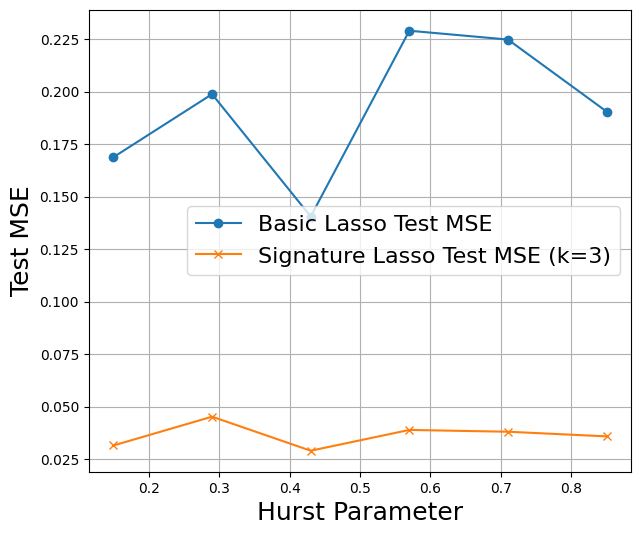

In [ ]:
# Two Dimensional FBMs
#

import numpy as np
import matplotlib.pyplot as plt
from fbm import FBM
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
import iisignature as isig

# Generate Hurst parameters
hurst_values = np.linspace(0.15, 0.85, 6)
n_realizations = 500
num_samples = 100
d = 2
noise_sigma = 0.1

def generate_fbm_data(hurst, n_realizations, num_samples, d=2):
    fbm_data = np.zeros((n_realizations, num_samples, d))
    for i in range(n_realizations):
        for j in range(d):
            path_dim = FBM(n=num_samples - 1, hurst=hurst).fbm()
            fbm_data[i, :, j] = path_dim
    return fbm_data

def add_time(X):
    times = np.tile(np.linspace(0, 1, X.shape[1]), (X.shape[0], 1))
    return np.concatenate([X, times.reshape(X.shape[0], X.shape[1], 1)], axis=2)

def get_sigX(X, k):
    if k == 0:
        return np.ones((X.shape[0], 1))
    else:
        d_in = X.shape[2]
        sig_dim = isig.siglength(d_in, k)
        sigX = np.zeros((X.shape[0], sig_dim + 1))
        sigX[:, 0] = 1.0
        for i in range(X.shape[0]):
            sigX[i, 1:] = isig.sig(X[i, :, :], k)
        return sigX

# Evaluate MSE for different Hurst values
final_mse_values = []
final_mse_values_sig = []
k = 3

for hurst in hurst_values:
    fbm_data = generate_fbm_data(hurst, n_realizations, num_samples, d)
    X_basic = 1 + fbm_data.reshape((n_realizations, -1), order='F')
    #np.random.seed(42)
     #Rainbow option I: OK
    Y_star = np.maximum((X_basic[:, num_samples-1]- X_basic[:, 2*num_samples-1]), 0) + noise_sigma * np.random.randn(n_realizations)

    #Rainbow option II: OK
    # Y_star = np.maximum(np.maximum(X_basic[:, num_samples-1], X_basic[:, 2*num_samples-1]) - 1.2, 0) + noise_sigma * np.random.randn(n_realizations)
    Xb_train, Xb_test, Yb_train, Yb_test = train_test_split(X_basic, Y_star, test_size=0.2, random_state=123)
    model_basic = LassoCV(random_state=123,  max_iter=10000)
    model_basic.fit(Xb_train, Yb_train)
    mse_test = np.mean((model_basic.predict(Xb_test) - Yb_test)**2)
    final_mse_values.append(mse_test)

    fbm_time = add_time(fbm_data)
    X_sig = get_sigX(fbm_time, k)
    Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(X_sig, Y_star, test_size=0.2, random_state=123)
    model_sig = LassoCV(random_state=123)
    model_sig.fit(Xs_train, Ys_train)
    mse_test_sig = np.mean((model_sig.predict(Xs_test) - Ys_test)**2)
    final_mse_values_sig.append(mse_test_sig)

    my_pred = np.mean(Ys_train)
    print(np.mean((my_pred - Ys_test)**2))



# Plot Test MSE vs Hurst
plt.figure(figsize=(7, 6))
plt.plot(hurst_values, final_mse_values, marker='o', label='Basic Lasso Test MSE')
plt.plot(hurst_values, final_mse_values_sig, marker='x', label=f'Signature Lasso Test MSE (k={k})')
plt.xlabel("Hurst Parameter", fontsize=18)
plt.ylabel("Test MSE", fontsize=18)
#plt.title("Test MSE vs Hurst Parameter for Basic and Signature Lasso", fontsize=18)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()
